# Exploratory Data Analysis

### Calculating the correlation between the continuous values and the target class.

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


df = pd.read_csv('working_dir/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
continuous = df.drop(columns=['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'])
discrete = df.drop(columns=['BMI', 'MentHlth','PhysHlth'])

is_continuous = {
    'Diabetes_binary': False,
    'HighBP': False,
    'HighChol': False,
    'CholCheck': False,
    'Smoker': False,
    'Stroke': False,
    'HeartDiseaseorAttack': False,
    'PhysActivity': False,
    'Fruits': False,
    'Veggies': False,
    'HvyAlcoholConsump': False,
    'AnyHealthcare': False,
    'NoDocbcCost': False,
    'GenHlth': False,
    'DiffWalk': False,
    'Sex': False,
    'Age': False,
    'Education': False,
    'Income': False,
    'BMI' : True,
    'MentHlth' : True,
    'PhysHlth' : True
    
        
}



### Plots of all the features

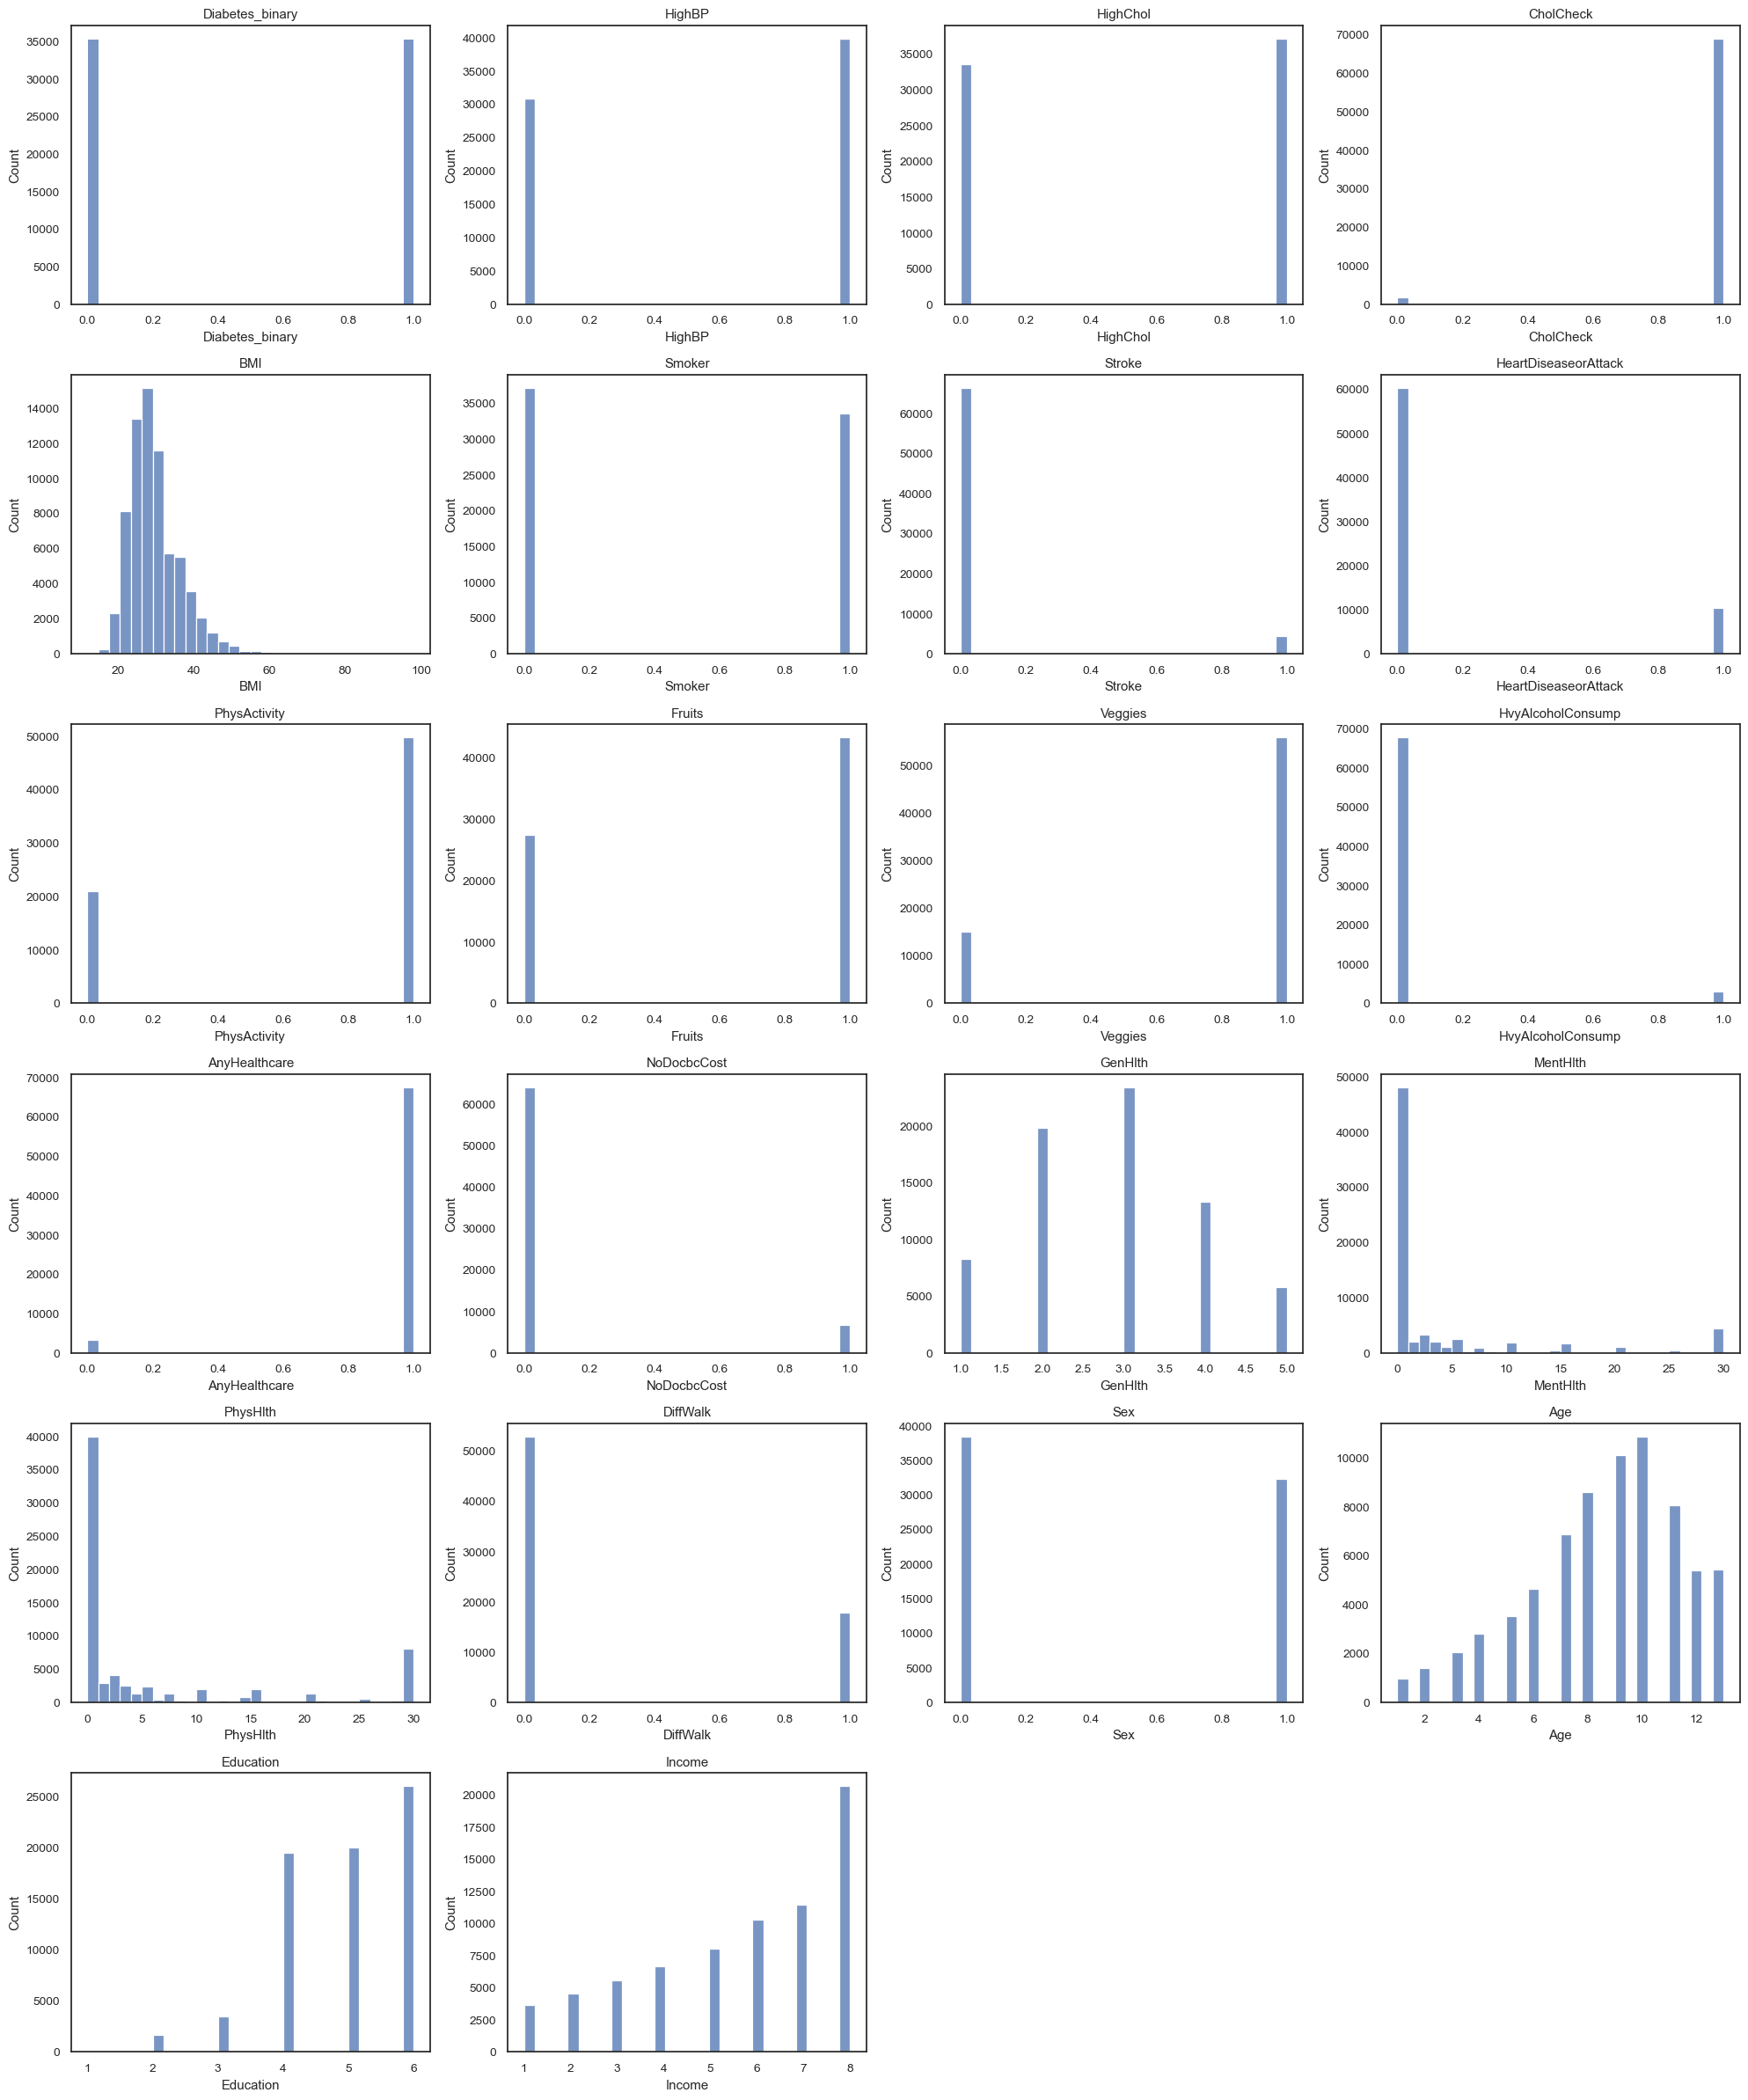

In [67]:

n_cols = 4
n_rows = (len(df.columns) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], bins=30, kde=False)
    plt.title(col)
    plt.tight_layout()

plt.show()


### Correlation between features and target
* Pearson correlation between continuous and continuous
* Point Biserial correlation between continuous and categorical
### Ignore the categorical and categorical features.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 89.00it/s]


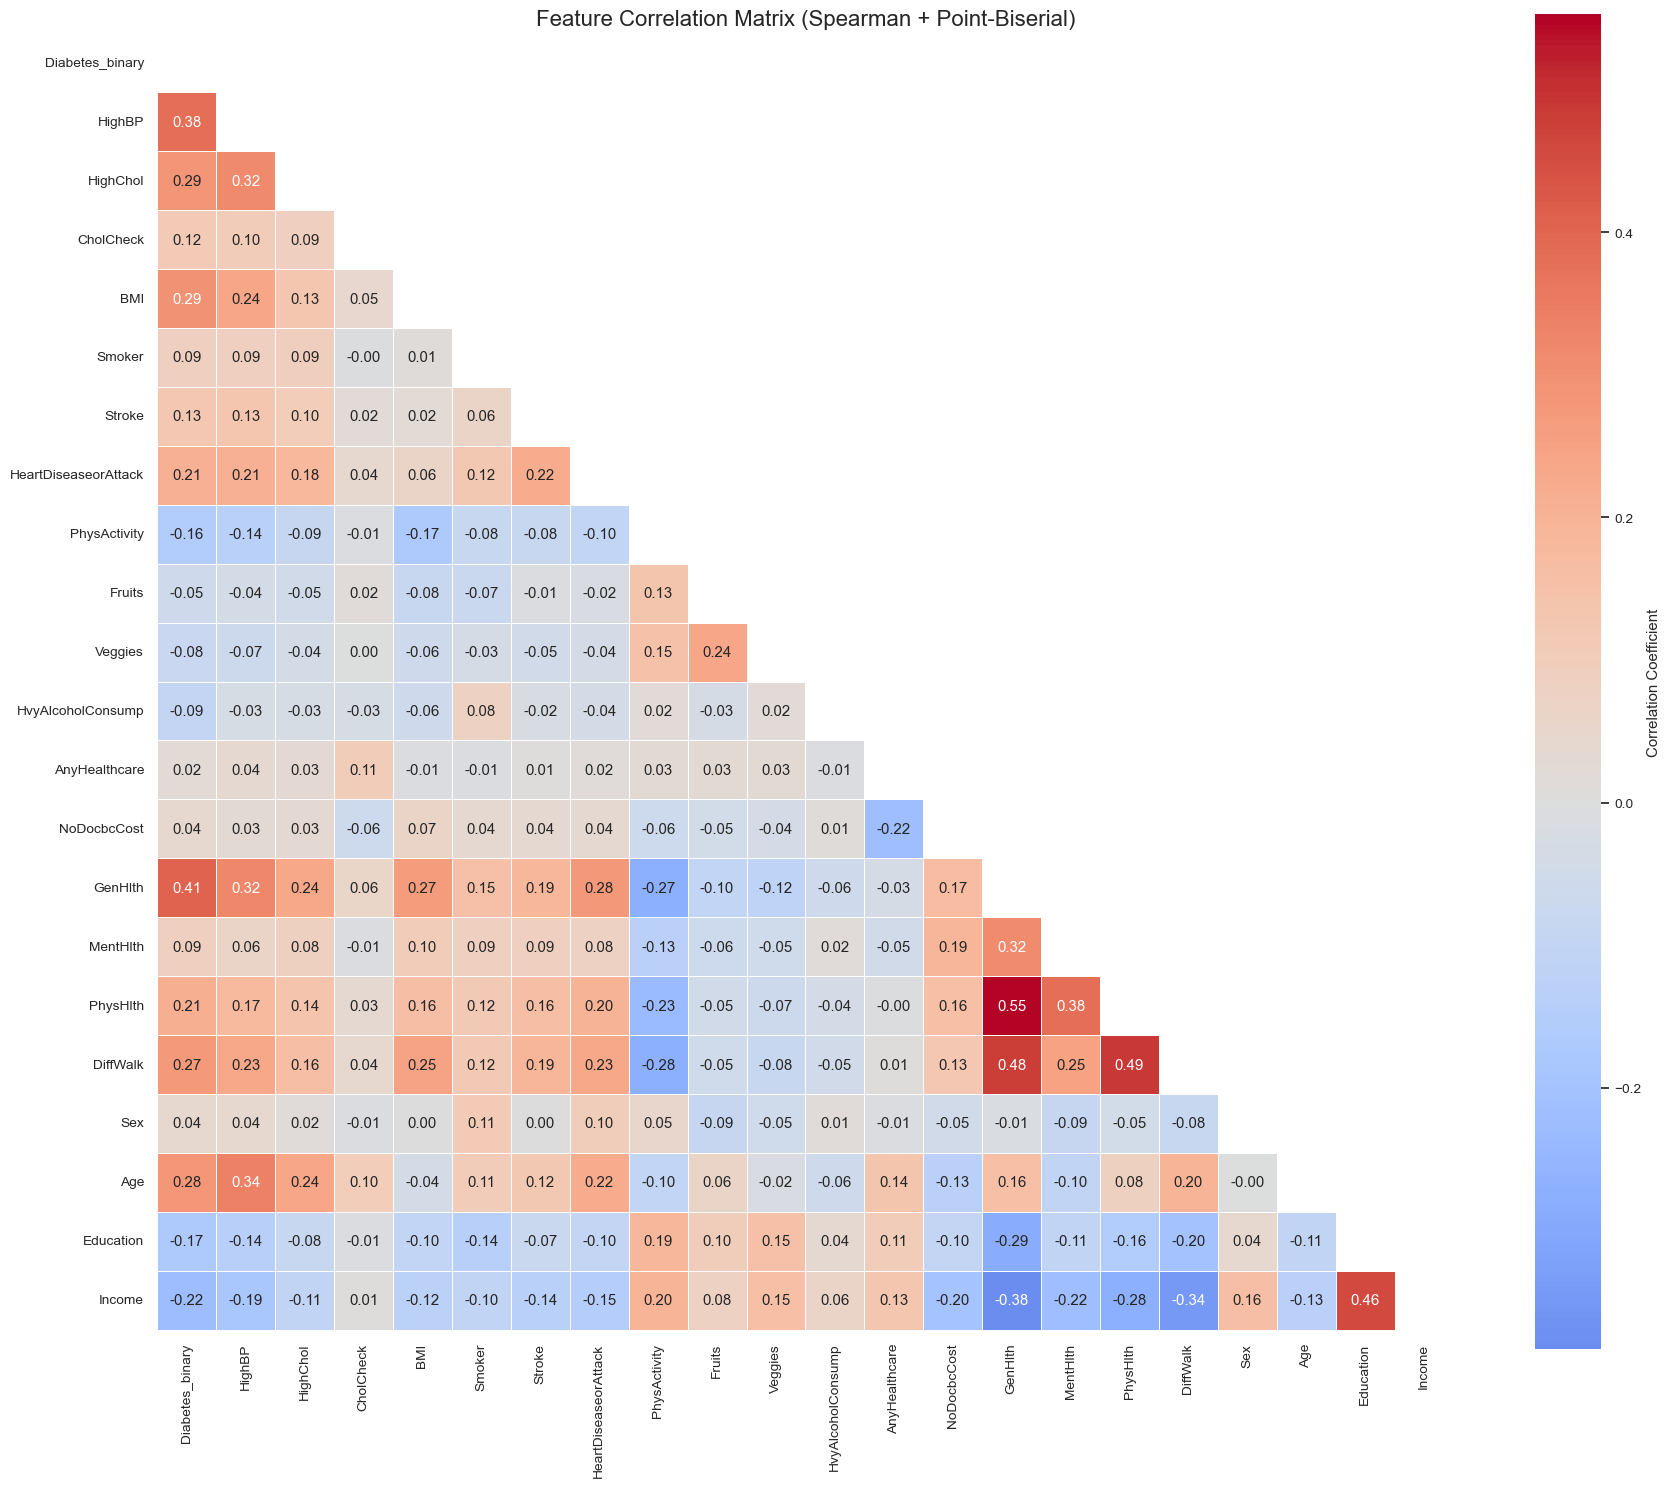

In [68]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, pointbiserialr, spearmanr
from tqdm import tqdm

# Initialize correlation matrix
corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)

# Compute correlations (lower triangle only)
for i, col1 in enumerate(tqdm(df.columns)):
    for j, col2 in enumerate(df.columns[:i+1]):
        x = df[col1]
        y = df[col2]

        if col1 == col2:
            corr = 1.0
        else:
            try:
                if is_continuous[col1] and is_continuous[col2]:
                    corr = pearsonr(x, y)[0]  # Phi coefficient
                elif is_continuous[col1]:
                    corr = pointbiserialr(y, x)[0]  # y must be continuous
                elif is_continuous[col2]:
                    corr = pointbiserialr(x, y)[0]
                else:
                    corr = pearsonr(x, y)[0]  # Use Spearman for non-linear
            except:
                corr = np.nan

        # Fill symmetric entries
        corr_matrix.loc[col1, col2] = corr
        corr_matrix.loc[col2, col1] = corr

# Plotting
plt.figure(figsize=(18, 15))
sns.set(style="white", font_scale=0.9)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    square=True,
    cbar_kws={"label": "Correlation Coefficient"},
    mask=mask
)

plt.title("Feature Correlation Matrix (Spearman + Point-Biserial)", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: Target variable correlations
if 'Diabetes_012' in df.columns:
    target_corr = corr_matrix['Diabetes_012'].sort_values(key=abs, ascending=False)
    print("\nTop correlations with Diabetes_012:")
    print(target_corr.head(10))

### Boxplots for the continuous values.  Outliers detected by IQR method.

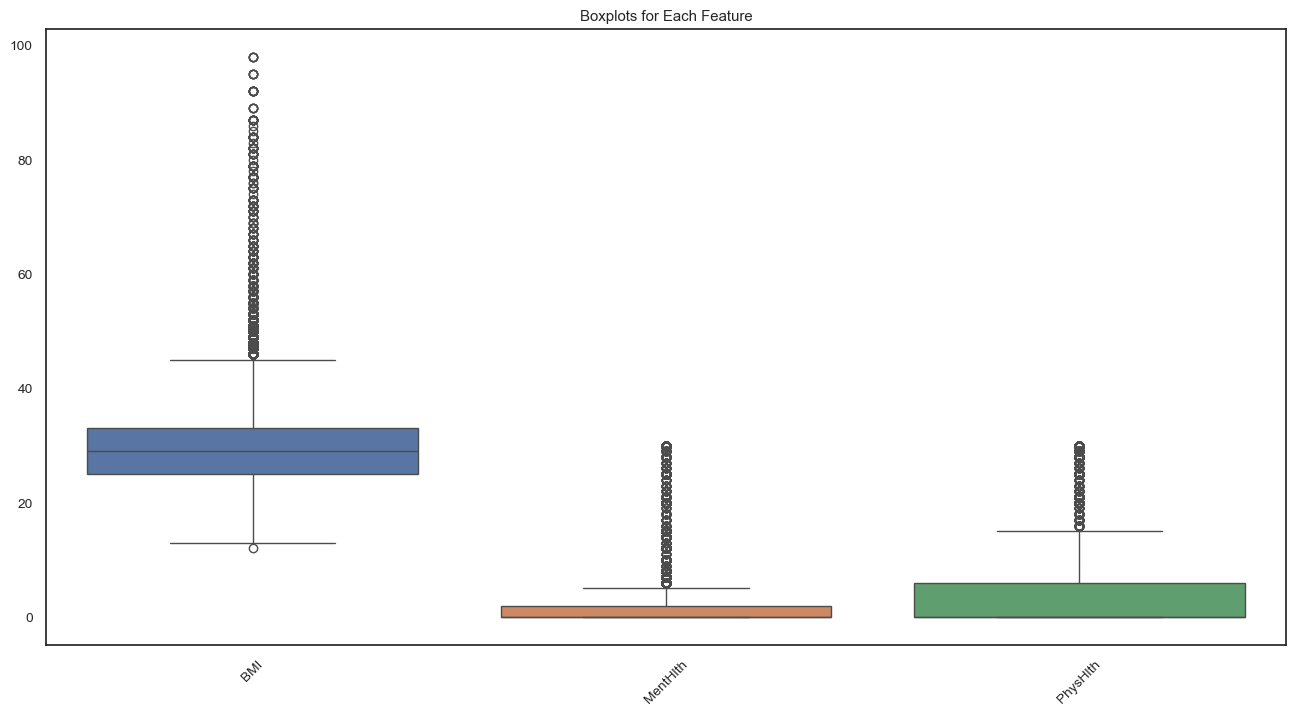

In [69]:
# Plot boxplots
plt.figure(figsize=(16, 8))
sns.boxplot(data=continuous)
plt.xticks(rotation=45)
plt.title('Boxplots for Each Feature')
plt.show()


### Cleaning Attempt 1: Tried removing the outliers
However, as shown below, almost half the data points were removed.  This means we likely lost a lot of important information.  Model accuracies did not increase either on the cleaned set.

In [70]:
# Step 1: Identify binary and continuous columns
categorical_cols = [col for col in df.columns if not is_continuous[col]]
continuous_cols = [col for col in df.columns if is_continuous[col]]

print("Binary columns:", categorical_cols)
print("Continuous columns:", continuous_cols)

# Step 2: Calculate Q1, Q2, Q3, IQR only for continuous columns
Q1 = df[continuous_cols].quantile(0.25)
Q2 = df[continuous_cols].quantile(0.50)  # Median
Q3 = df[continuous_cols].quantile(0.75)
IQR = Q3 - Q1

print("\nQ1:\n", Q1)
print("\nQ2 (Median):\n", Q2)
print("\nQ3:\n", Q3)
print("\nIQR:\n", IQR)

# Step 3: Remove outliers for continuous columns only
# (Categorical columns are untouched)
filter_condition = ~((df[continuous_cols] < (Q1 - IQR)) | (df[continuous_cols] > (Q3 + IQR))).any(axis=1)
df_clean = df[filter_condition]

print("\nOriginal shape:", df.shape)
print("Cleaned shape:", df_clean.shape)

Binary columns: ['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Continuous columns: ['BMI', 'MentHlth', 'PhysHlth']

Q1:
 BMI         25.0
MentHlth     0.0
PhysHlth     0.0
Name: 0.25, dtype: float64

Q2 (Median):
 BMI         29.0
MentHlth     0.0
PhysHlth     0.0
Name: 0.5, dtype: float64

Q3:
 BMI         33.0
MentHlth     2.0
PhysHlth     6.0
Name: 0.75, dtype: float64

IQR:
 BMI         8.0
MentHlth    2.0
PhysHlth    6.0
dtype: float64

Original shape: (70692, 22)
Cleaned shape: (47032, 22)


### Cleaning Attempt 2: 
We learned that the outliers were important to predicting diabetes based on the previous cleaning attempt and literature review on all 21 features, so we decided to keep all the outliers in the dataset.

However, the data was highly skewed because of the continuous variable outliers.  To reduce this skewdness, the method we used was to make all the continuous features categorical. 

Here is how the features were converted in the original dataset:

'BMI': 

    < 18.5 = 0
    18.6 to 24.9 = 1
    25.0 to 29.9 = 2
    30.0 to 34.9 = 3
    > 34.9 = 4

'MentHlth':

    0 = 0
    0.1 to 10 = 1
    10.1 to 20 = 2
    20.1 to 30 = 3
    > 30 = 4
    
'PhyHlth':

    0 = 0
    0.1 to 10 = 1
    10.1 to 20 = 2
    20.1 to 30 = 3
    > 30 = 4

  
    

### Feature Selection

The second cleaning attempt worked better and brought the model accuracies much higher.  This allowed us to conclude that the outliers were important.  

According to the literature review, all features were important, however we still wanted to notice the best best features based on chi-square test for categorical features and target

In [75]:
from sklearn.feature_selection import chi2, SelectKBest

df = pd.read_csv('3_to_classes_.csv')

X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

selector = SelectKBest(chi2, k=13)
selector.fit_transform(X, y)

feature_scores = selector.scores_
selected_features = X.columns[selector.get_support()]

print("Selected Features:", selected_features)

Selected Features: Index(['HighBP', 'HighChol', 'NEW_BMI_class', 'Stroke', 'HeartDiseaseorAttack',
       'PhysActivity', 'HvyAlcoholConsump', 'GenHlth', 'MetHlth_Class',
       'PhyHlth_Class', 'DiffWalk', 'Age', 'Income'],
      dtype='object')


### Plots after making the continuous into categorical

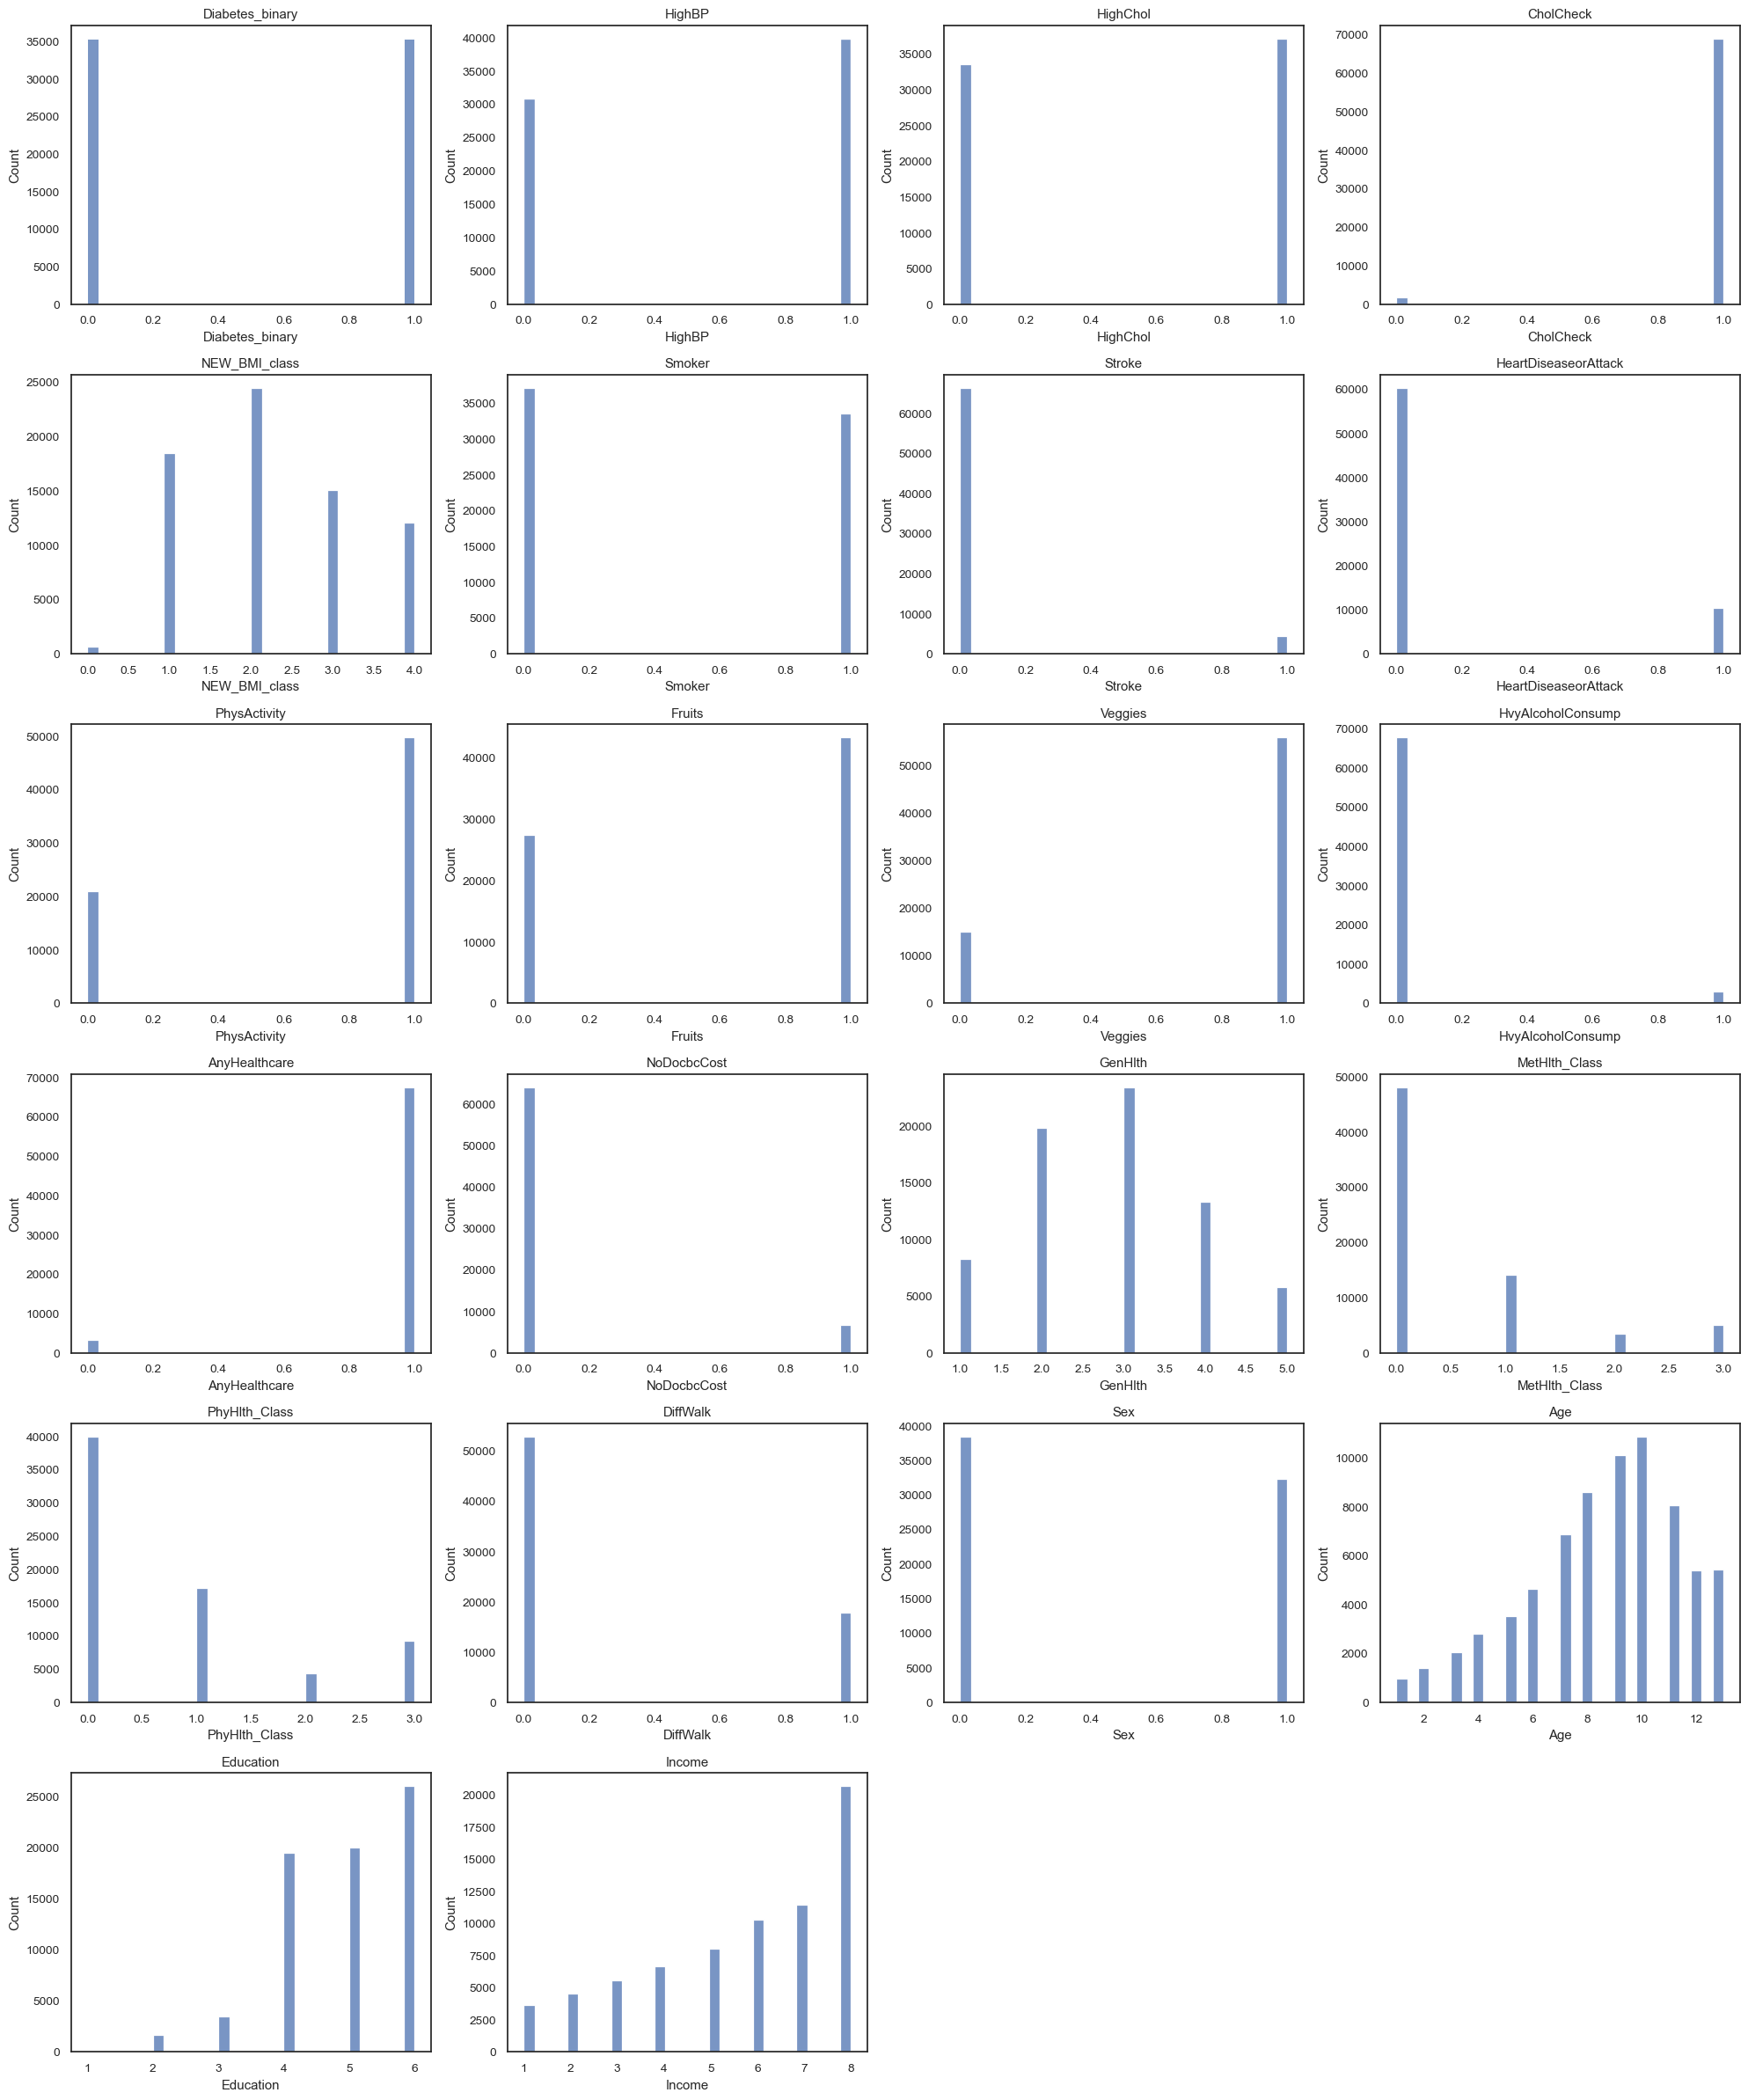

In [76]:

n_cols = 4
n_rows = (len(df.columns) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], bins=30, kde=False)
    plt.title(col)
    plt.tight_layout()

plt.show()
